http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [28]:
import os
import sys
import numpy
import scipy, pylab
import scipy.io.wavfile as wave

import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.fftpack import dct
%matplotlib inline

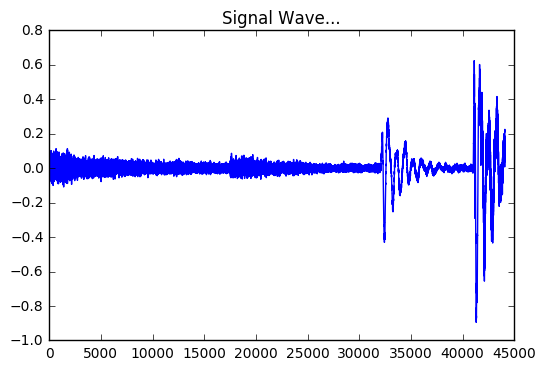

44100 (44100,)


In [29]:
ffile = 'audio/drums.wav'
sample_rate, signal = wave.read(ffile)


#f0 = 440         # Compute the STFT of a 440 Hz sinusoid
#sample_rate = 8000        # sampled at 8 kHz
#T = 5            # lasting 5 seconds
# Create test signal and STFT.
#t = scipy.linspace(0, T, T*fs, endpoint=False)
#signal = scipy.sin(2*scipy.pi*f0*t)

#sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
#signal = signal[0:int(3.5 * sample_rate)]





mx = max(signal.min(), signal.max(), key=abs)
signal = signal/(mx + 1e-08)

signal = signal[int(10 * sample_rate):int(11 * sample_rate)]

plt.figure(1)
plt.title('Signal Wave...')
plt.plot(signal)
plt.show()
print( sample_rate, signal.shape)

<h4>Framing</h4>
<p>After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would loose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.</p>

<p>Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.</p>


In [30]:
frame_size = 0.025 
frame_stride = 0.01
emphasized_signal = signal

In [31]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [32]:
frames *= numpy.hamming(frame_length)

<h4>Fourier-Transform and Power Spectrum</h4>

In [33]:
NFFT = 512

In [34]:
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

<h4>Filter bank</h4>

In [38]:
nfilt = 32# 128

In [48]:
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

normalized_filter_banks = filter_banks - (numpy.mean(filter_banks, axis=0) + 1e-8)

print( filter_banks.shape )

(98, 32)


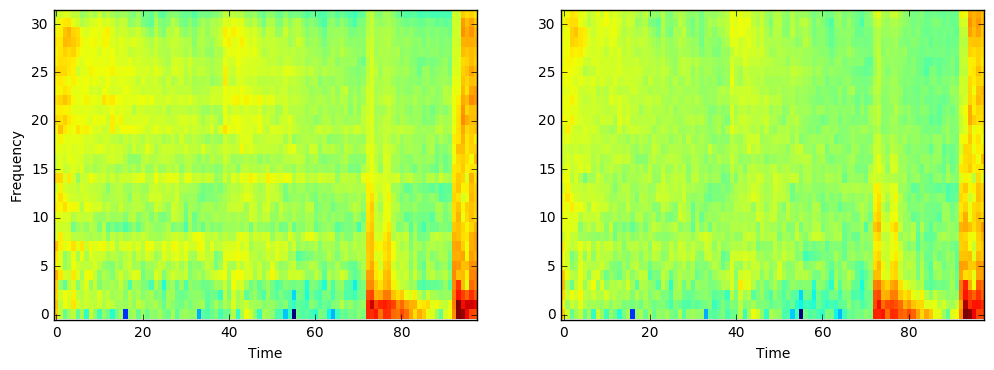

In [50]:
fig= pylab.figure( figsize=(12, 4), dpi=320,)
a=fig.add_subplot(1,2,1)
pylab.imshow(filter_banks.T, origin='lower', aspect='auto', interpolation='nearest' )
pylab.xlabel('Time')
pylab.ylabel('Frequency')

a=fig.add_subplot(1,2,2)
pylab.imshow(normalized_filter_banks.T, origin='lower', aspect='auto', interpolation='nearest') #, cmap='gray')
pylab.xlabel('Time')
pylab.show()

<h4>Mel-frequency Cepstral Coefficients</h4>

In [41]:
num_ceps = 128#128 #12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

<h2>Why 22:????????</h2>

In [42]:
cep_lifter = 22
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

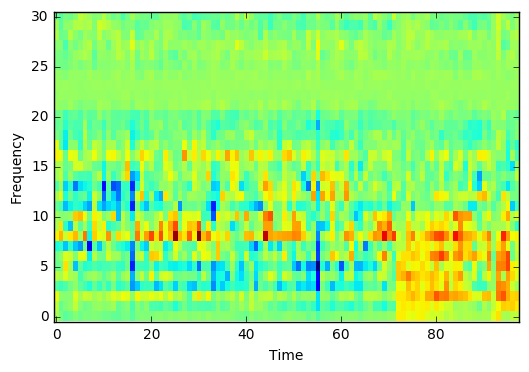

In [43]:
pylab.figure()
pylab.imshow(mfcc.T, origin='lower', aspect='auto', interpolation='nearest')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

<h4>Mean normalization</h4>

In [44]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

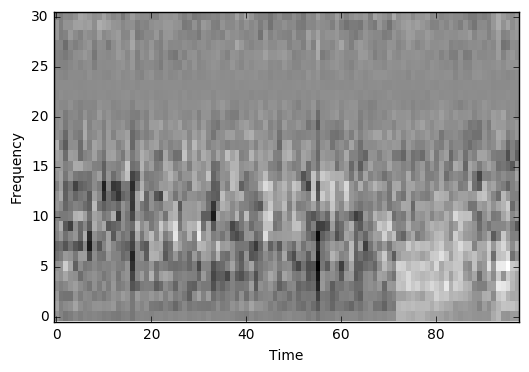

In [45]:
pylab.figure()
pylab.imshow(mfcc.T, origin='lower', aspect='auto', interpolation='nearest', cmap='gray')
pylab.xlabel('Time')
pylab.ylabel('Frequency')
pylab.show()

In [17]:
mfcc.shape





(198, 127)